In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [63]:
df=pd.read_csv('D:\\Sherif\\Data Science\\Company-monthly-sales.csv')

In [64]:
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   106 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [66]:
df.shape

(107, 2)

In [67]:
df.dropna(inplace=True)

In [68]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [69]:
df["Month"] = pd.to_datetime(df["Month"])
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [70]:
df.set_index('Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [71]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


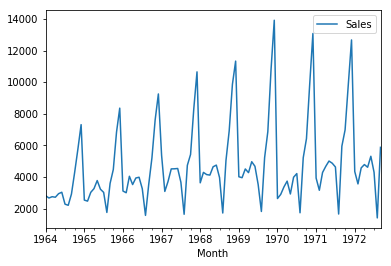

In [72]:
df.plot();
plt.show()

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


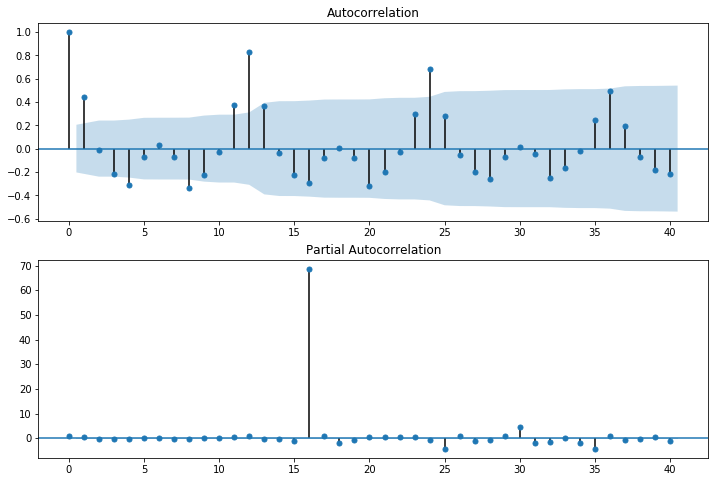

In [73]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Sales'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Sales'].iloc[13:],lags=40,ax=ax2)

plt.show()

Plotting the data that shows it has different mean across the time, the ACF and PACF plots, its clear that the data is not stationary. However, using dickey fuller test would ensure.

In [75]:
### Testing data Stationarity

import statsmodels
from statsmodels.tsa.stattools import adfuller

In [76]:
result=adfuller(df['Sales'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.8335930563276184
p-value: 0.36391577166024713
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}


#### Since p-value is greater than 0.05, we fail to reject null hypothesis that supposes the data is not stationary

### Transforming the data into stationary using differencing

In [77]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)

In [78]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [79]:
df.head(15)

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [80]:
## Again test dickey fuller test
result=adfuller(df['Sales First Difference'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -7.18989644805098
p-value: 2.519620447387365e-10
Critical Values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


In [81]:
## Again test dickey fuller test
result=adfuller(df['Seasonal First Difference'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -7.626619157213164
p-value: 2.060579696813685e-11
Critical Values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


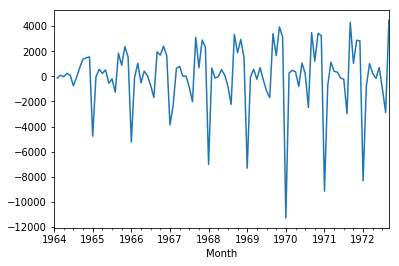

In [82]:
df['Sales First Difference'].plot()
plt.show()

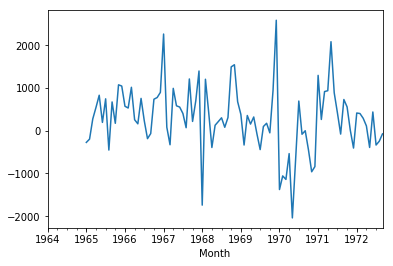

In [83]:
df['Seasonal First Difference'].plot()
plt.show()

It is clear that the data has strong seasonal patterns which makes the SARIMA model performs much better than ARIMA model for forecasting. However, let's start by ARIMA to see the difference

## ARIMA Model

To determine how many lags shuould be used in AR model (p parameter), we would use Autocorrelatin

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


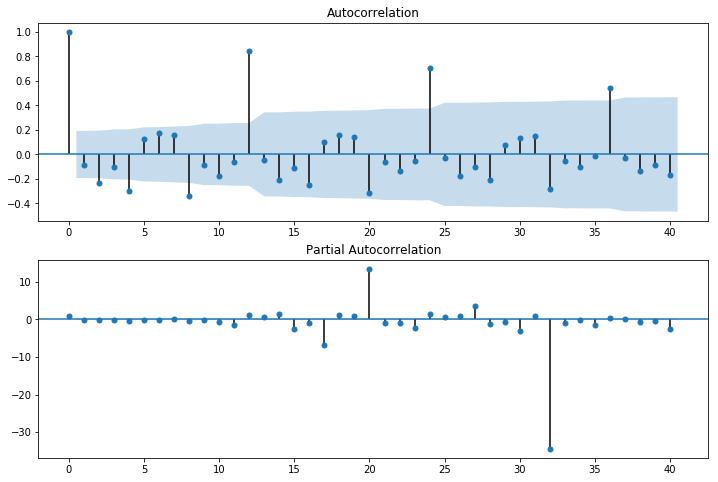

In [84]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Sales First Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Sales First Difference'].iloc[1:],lags=40,ax=ax2)
plt.show()

Let's try using ARIMA model with p=1 (# of lags) and q=1 (error lag) and d=1 (differencing)

In [85]:
from statsmodels.tsa.arima_model import ARIMA

In [86]:
model1=ARIMA(df['Sales'],order=(1,1,1))
model1_fit=model1.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, Valu

In [87]:
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Tue, 17 Dec 2024   AIC                           1910.251
Time:                        16:02:55   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7839     12.405      1.837      0.066      -1.530      47.098
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

After fitting the model with our sales data, let's try to use it for forecasting a specific period that we already have its sales values

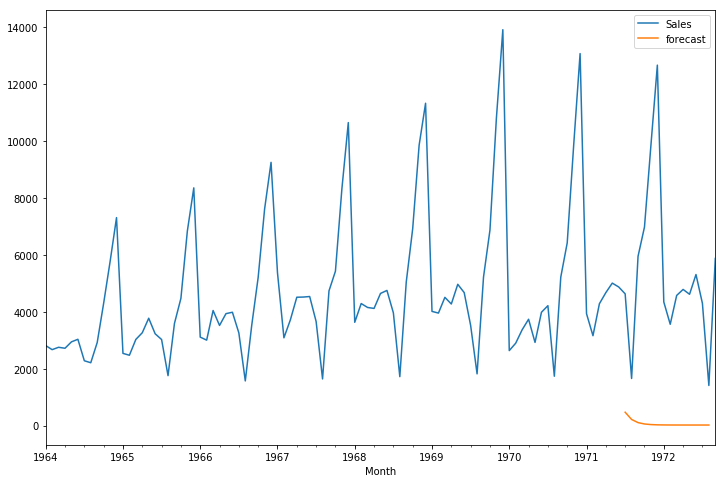

In [88]:
df['forecast']=model1_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))
plt.show()

From the summary of the model, AIC and BIC values and how the model forecast the last period of our data, low model performance is obvious because of the data seasonal patterns that ARIMA can't handle.

## SARIMA model

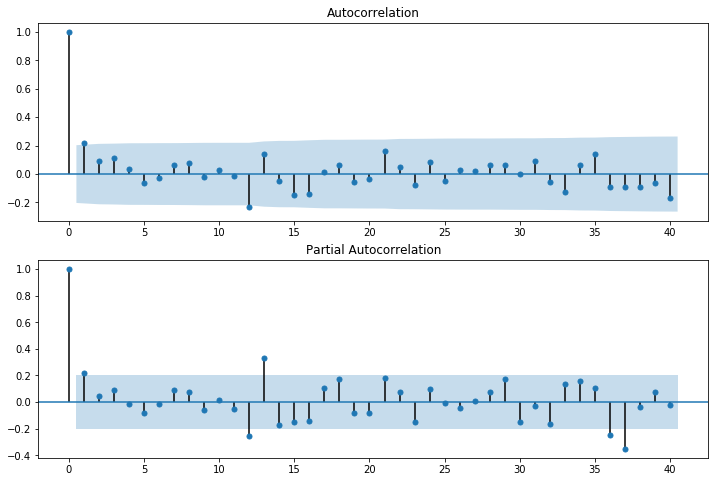

In [89]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[12:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[12:],lags=40,ax=ax2)
plt.show()

In [90]:
import statsmodels.api as sm

In [91]:
for p in range(1,4) :
    print("p : ", p)
    model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(p, 1, 1),seasonal_order=(p,1,1,12))
    results=model.fit()
    print(results.summary())

p :  1


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Tue, 17 Dec 2024   AIC                           1486.804
Time:                                    16:03:09   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043   

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -737.137
Date:                            Tue, 17 Dec 2024   AIC                           1488.274
Time:                                    16:03:12   BIC                           1505.927
Sample:                                01-01-1964   HQIC                          1495.399
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2913      0.079      3.678      0.000       0.136       0.446
ar.L2         -0.0244      0.102   

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood                -738.258
Date:                            Tue, 17 Dec 2024   AIC                           1494.515
Time:                                    16:03:19   BIC                           1517.212
Sample:                                01-01-1964   HQIC                          1503.676
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2869      0.085      3.368      0.001       0.120       0.454
ar.L2         -0.0307      0.098   

the model's best performance was with number of lags = 1.

In [92]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Tue, 17 Dec 2024   AIC                           1486.804
Time:                                    16:03:19   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

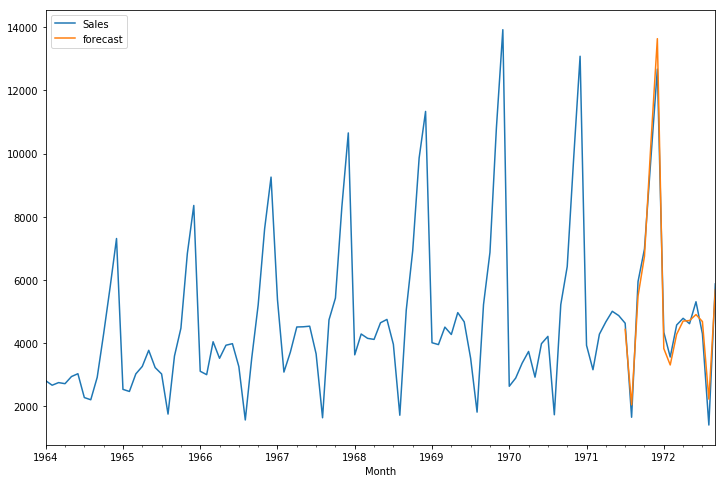

In [93]:
df['forecast']=results.predict(start=90,end=105,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))
plt.show()

#### SARIMA model has much more ability to forecast the last period of the data and ready for forecasting future sales.

In [94]:
df.head()

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN


In [95]:
df.tail()

,Sales,Sales First Difference,Seasonal First Difference,forecast
Month,,,,
1972-05-01,4618.0,-170.0,-392.0,4717.511045
1972-06-01,5312.0,694.0,438.0,4906.404090
1972-07-01,4298.0,-1014.0,-335.0,4685.436633
1972-08-01,1413.0,-2885.0,-246.0,2232.408592
1972-09-01,5877.0,4464.0,-74.0,5686.557944


In [96]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [97]:
future_datest_df.head()

,Sales,Sales First Difference,Seasonal First Difference,forecast
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN


In [98]:
future_datest_df.shape

(23, 4)

In [99]:
future_df=pd.concat([df,future_datest_df])

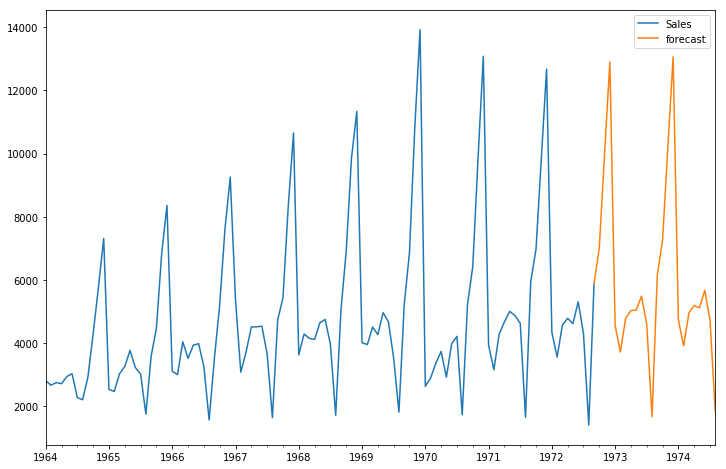

In [100]:
future_df['forecast'] = results.predict(start = 104, end = 129, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 
plt.show()